In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os

In [2]:
matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/featureMatrix/2_keyword_matrix_stemmed.csv', index_col=0)
y_data = matrix[['BDSPPatientID', 'NoteTitle', 'annot']]
X = matrix.drop(columns=['BDSPPatientID', 'NoteDate', 'NoteTitle', 'text', 'hospital', 'annot'])
X.head()

,ICD,doubl vision,diplopia,headach,sudden,neck pain,nausea,vomit,dizzi,photophobia,...,neg_am,neg_cta,neg_angio,neg_neuro,neg_av,neg_iph,neg_auto,neg_car,neg_loc,neg_trauma
0,1,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = y_data['annot']
y.head()

0    0
1    1
2    0
3    1
4    0
Name: annot, dtype: int64

In [4]:
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_params = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store patient IDs for each fold
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(5)}

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}

# Initialize KFold
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X,y):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]

    model = RandomForestClassifier(random_state=2024, n_jobs=-1)
   
    search_spaces = {
         'n_estimators': (10, 1000),
         'max_features': (0.1, 0.9999, 'log-uniform'),
         'max_depth': (2, 50),
         'min_samples_split': (2, 10),
         'min_samples_leaf': (1, 10),
    }
    model_cv = BayesSearchCV(model,
            search_spaces,
            n_iter=50, scoring='roc_auc', n_jobs=-1,
            cv=5, random_state=2024)
    
    model_cv.fit(Xtr, ytr)

    # Find the Best hyperparameters and append them
    best_hparams = model_cv.best_params_
    final_params.append(best_hparams)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:,1]      # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
    yte_pred = model.predict_proba(Xte)[:,1]    # Xte is testing features

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred)

    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)

    # Store the predictions and true labels for this fold
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances
    feature_importances = model.feature_importances_
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

RF_fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        RF_fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        RF_fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})
RF_fold_patient_ids_df = pd.DataFrame(RF_fold_patient_ids_list)
RF_fold_patient_ids_df.to_csv('RF_fold_patient_ids.csv', index=False)

Feature importances for this fold:
                    Feature  Importance
67                      sah    0.175347
75             subarachnoid    0.102772
83                nimodipin    0.080225
64   subarachnoid hemorrhag    0.076976
23                 aneurysm    0.035461
..                      ...         ...
77                     acom    0.000325
111                neg_numb    0.000203
98                   struck    0.000169
20                asymmetri    0.000131
89                     hess    0.000029

[122 rows x 2 columns]
[0.9888586956521739]
[0.9691420618446638]
Feature importances for this fold:
                    Feature  Importance
67                      sah    0.184768
75             subarachnoid    0.122782
83                nimodipin    0.092119
64   subarachnoid hemorrhag    0.076657
23                 aneurysm    0.040391
..                      ...         ...
36       cerebr angiographi    0.000235
20                asymmetri    0.000208
111                neg_n

In [5]:
# Calculate and print average AUC and PR
print(np.mean(auc_cv))
print(np.mean(auc_pr))

0.9784082453643208
0.9354426169311212


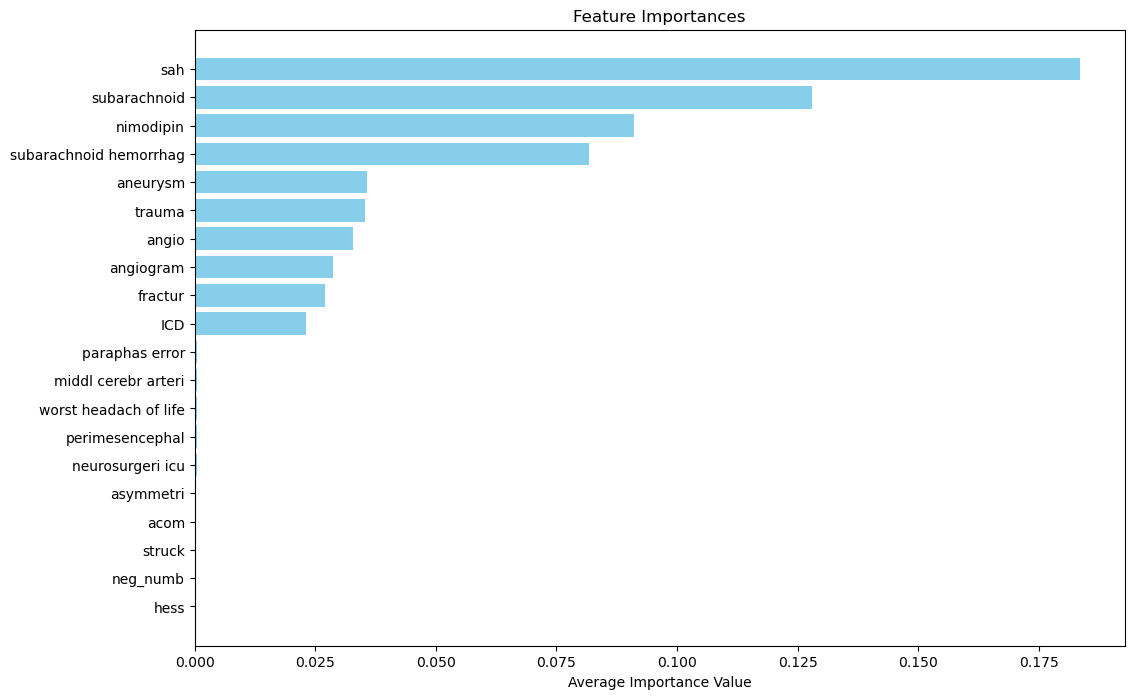

In [6]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Define the output directory
output_dir = '/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/RandForest'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_dir, 'feat_importances.csv')
feature_importance_df.to_csv(csv_file_path, index=False)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Importance Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# Save the plot to a PNG file
plt.savefig(os.path.join(output_dir, 'feat_importances.png'))
plt.show()

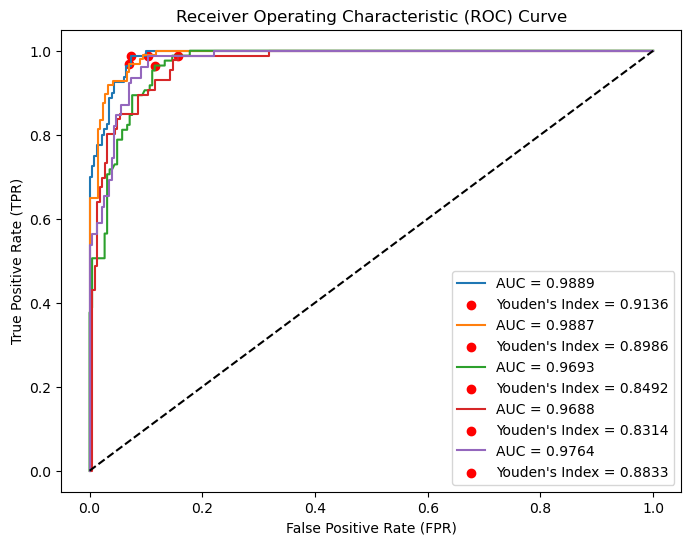

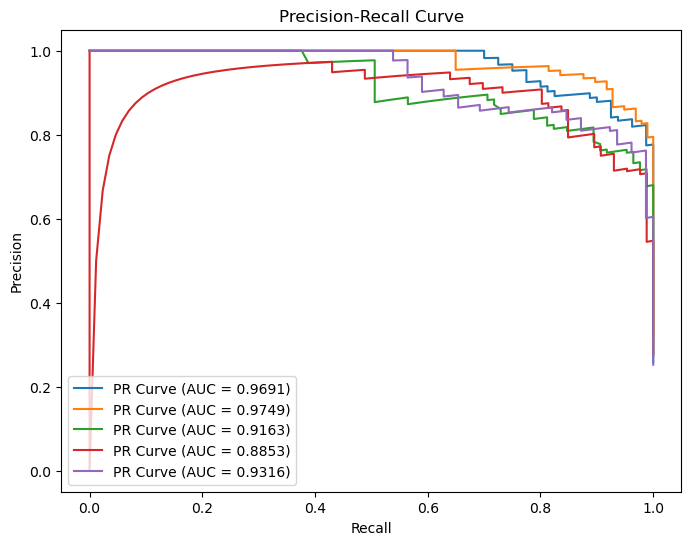

0.9784082453643208
0.846850238499649


In [10]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr - fpr)
    plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'AUC_iter.png'))
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(os.path.join(output_dir, 'PR_iter.png'))
plt.show()

# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv(os.path.join(output_dir, 'RF_iter_pred_rr.csv'), index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['params'] = final_params
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1, df2, df3, df4, df5]).reset_index()
df.to_csv(os.path.join(output_dir, 'RF_iter.csv'))

# Print final Data
print(auc_final)
print(f1_final)

In [8]:
print(final_params)

[OrderedDict({'max_depth': 45, 'max_features': 0.19522063968273035, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 870}), OrderedDict({'max_depth': 27, 'max_features': 0.2606982519195951, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1000}), OrderedDict({'max_depth': 49, 'max_features': 0.31978411447976957, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 997}), OrderedDict({'max_depth': 49, 'max_features': 0.2068484496332201, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 96}), OrderedDict({'max_depth': 47, 'max_features': 0.24827829933372325, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 623})]


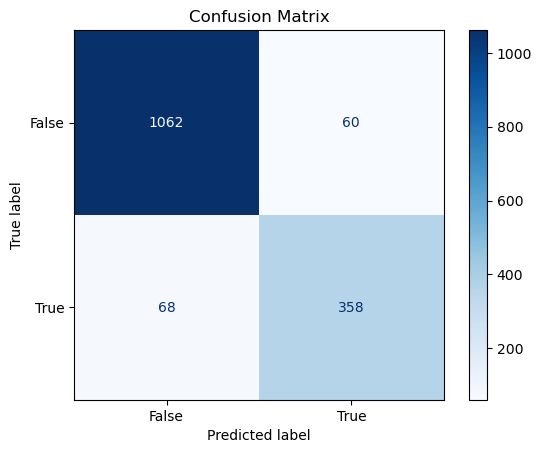

[[1062   60]
 [  68  358]]


In [9]:
# Create the confusion matrix
cf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[False, True])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'cf_matrix.png'))
plt.show()

# Print the confusion matrix
print(cf_matrix)

In [11]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1
# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

Metrics for Fold 1:
Accuracy: 0.9290
Precision: 0.9143
Recall: 0.8000
F1 Score: 0.8533

Metrics for Fold 2:
Accuracy: 0.9419
Precision: 0.9438
Recall: 0.8660
F1 Score: 0.9032

Metrics for Fold 3:
Accuracy: 0.8935
Precision: 0.8611
Recall: 0.7294
F1 Score: 0.7898

Metrics for Fold 4:
Accuracy: 0.8997
Precision: 0.7723
Recall: 0.9070
F1 Score: 0.8342

Metrics for Fold 5:
Accuracy: 0.9223
Precision: 0.8140
Recall: 0.8974
F1 Score: 0.8537

Overall Metrics:
Accuracy: 0.9173
Precision: 0.8565
Recall: 0.8404
F1 Score: 0.8483
